In [ ]:
%%capture
!pip install python-graphblas

In [ ]:
!gdown 1zRLt0DWI5J_tb8q3AoNukjR2n1b_tvc6
!unzip graphs.zip
!rm -rf graphs.zip

In [12]:
import graphblas as gb

gb.init("suitesparse", blocking=False)

from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder
from graphblas.io import mmread
import numpy as np

Скачал данные с SuiteSparse Matrix Collection

In [283]:
M = mmread('graphs/data.mtx')

In [284]:
M

"M_154298"  nvals  nrows  ncols  dtype     format
gb.Matrix   30186   2851   2851   FP64  csr (iso)
-------------------------------------------------
     0    1    2    3    4    5    6    7    8    9     ... 2841 2842 2843  \
0          1.0  1.0  1.0  1.0  1.0  1.0                 ...                  
1     1.0       1.0  1.0  1.0  1.0       1.0            ...                  
2     1.0  1.0       1.0  1.0       1.0  1.0  1.0  1.0  ...                  
3     1.0  1.0  1.0            1.0  1.0  1.0  1.0  1.0  ...                  
4     1.0  1.0  1.0            1.0  1.0  1.0            ...                  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2846                                                    ...                  
2847                                                    ...                  
2848                                                    ...                  
2849                                                    ...                  
2850                                                    ...                  

     2844 2845 2846 2847 2848 2849 2850  
0                                        
1                                        
2                                        
3                                        
4                                        
...   ...  ...  ...  ...  ...  ...  ...  
2846       1.0       1.0                 
2847            1.0       1.0            
2848                 1.0       1.0       
2849                      1.0       1.0  
2850                           1.0

## Реализация методов

In [285]:
def naiveA3(A):
    A3 = gb.Matrix(A.dtype, A.nrows, A.ncols)
    A3 << A.mxm(A.mxm(A))
    traingle = A3.diag().reduce(gb.agg.sum).value or 0
    return int(traingle) // 6

In [286]:
print(f"Наивный подход третья степень: {naiveA3(M)} треугольников")

Наивный подход третья степень: 24442 треугольников


In [287]:
def naiveMaskA2(A):
    A2 = gb.Matrix(A.dtype, A.nrows, A.ncols)
    A2(A.S) << A.mxm(A)
    return int(A2.reduce_scalar(gb.agg.sum).value or 0) // 6

In [288]:
print(f"Наивный подход вторая степень + маска: {naiveMaskA2(M)} треугольников")

Наивный подход вторая степень + маска: 24442 треугольников


In [289]:
def cohen(A):
  tril_A = gb.Matrix(A.dtype, A.nrows, A.ncols)
  triu_A = gb.Matrix(A.dtype, A.nrows, A.ncols)
  tril_triu_A = gb.Matrix(A.dtype, A.nrows, A.ncols)
  tril_A << gb.select.tril(A)
  triu_A << gb.select.triu(A)
  tril_triu_A(A.S) << tril_A.mxm(triu_A)
  return int(tril_triu_A.reduce_scalar(gb.agg.sum).value or 0) // 2

In [290]:
print(f"Метод Cohen: {cohen(M)} треугольников")

Метод Cohen: 24442 треугольников


In [291]:
def sandia(A):
  tril_A = gb.Matrix(A.dtype, A.nrows, A.ncols)
  tril_A_2 = gb.Matrix(A.dtype, A.nrows, A.ncols)
  tril_A << gb.select.tril(A)
  tril_A_2(A.S) << tril_A.mxm(tril_A)
  return int(tril_A_2.reduce_scalar(gb.agg.sum).value or 0)

In [292]:
print(f"Метод Sandia: {sandia(M)} треугольников")

Метод Sandia: 24442 треугольников


## Оценка скорости (Дополнительно)

**Скачал данные с SuiteSparse Matrix Collection (10 разных графов от 10000 до 80000 ненулевых значений для оценки скорости работы алгоритма)**

In [295]:
import time
import os
import matplotlib.pyplot as plt

In [301]:
def calculate_time(A):
    result = [naiveA3(A), naiveMaskA2(A), cohen(A), sandia(A)]
    if not all(element == element for element in result):
        print("All return values are not equal")
    else:
        start_time = time.time()
        naiveA3(A)
        naive_a3_time = time.time() - start_time

        start_time = time.time()
        naiveMaskA2(A)
        naive_mask_a2_time = time.time() - start_time

        start_time = time.time()
        cohen(A)
        cohen_time = time.time() - start_time

        start_time = time.time()
        sandia(A)
        sandia_time = time.time() - start_time

        return naive_a3_time, naive_mask_a2_time, cohen_time, sandia_time

In [309]:
results = {}
for filename in os.listdir('graphs'):
    if filename.endswith('.mtx'):
        filepath = os.path.join('graphs', filename)
        M = mmread(filepath)
        nonzero_count = M.nvals
        times = calculate_time(M)
        results[nonzero_count] = times
results = dict(sorted(results.items()))

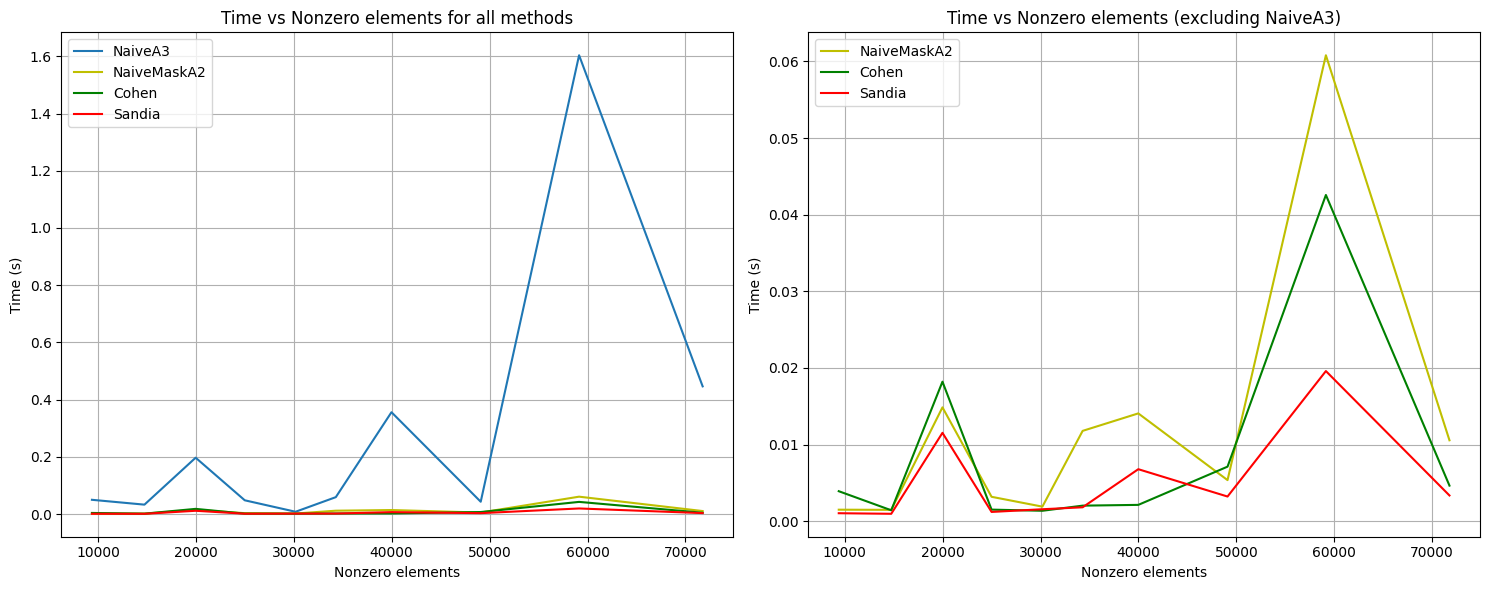

In [321]:
nonzero_count_list = list(results.keys())
naive_a3_times = [results[count][0] for count in nonzero_count_list]
naive_mask_a2_times = [results[count][1] for count in nonzero_count_list]
cohen_times = [results[count][2] for count in nonzero_count_list]
sandia_times = [results[count][3] for count in nonzero_count_list]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(nonzero_count_list, naive_a3_times, label='NaiveA3')
ax1.plot(nonzero_count_list, naive_mask_a2_times, label='NaiveMaskA2',color='y')
ax1.plot(nonzero_count_list, cohen_times, label='Cohen', color='g')
ax1.plot(nonzero_count_list, sandia_times, label='Sandia', color='r')
ax1.set_xlabel('Nonzero elements')
ax1.set_ylabel('Time (s)')
ax1.set_title('Time vs Nonzero elements for all methods')
ax1.legend()
ax1.grid(True)

ax2.plot(nonzero_count_list, naive_mask_a2_times, label='NaiveMaskA2', color='y')
ax2.plot(nonzero_count_list, cohen_times, label='Cohen', color='g')
ax2.plot(nonzero_count_list, sandia_times, label='Sandia', color='r')
ax2.set_xlabel('Nonzero elements')
ax2.set_ylabel('Time (s)')
ax2.set_title('Time vs Nonzero elements (excluding NaiveA3)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()

## Алгоритм вычисления для каждой вершины графа количество треугольников

In [322]:
MyMatrix = gb.Matrix.from_coo(
  [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 4, 4],
  [1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 0, 1, 0, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
ncols=5, nrows=5) # пример матрицы смежности с лекции

In [323]:
MyMatrix

"M_187771"  nvals  nrows  ncols  dtype         format
gb.Matrix      14      5      5  INT64  bitmapr (iso)
-----------------------------------------------------
   0  1  2  3  4
0     1  1  1  1
1  1     1  1  1
2  1  1         
3  1  1         
4  1  1

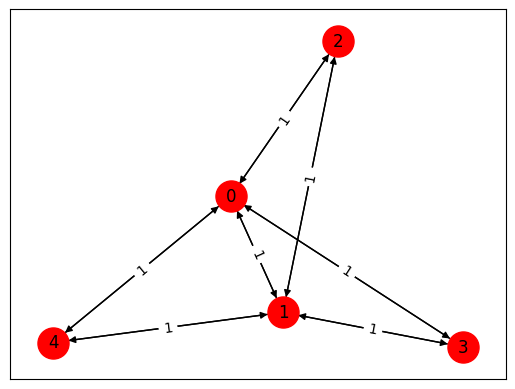

In [325]:
gb.viz.draw(MyMatrix) # можно увидеть: "0" - 3, "1" - 3, "2" - 1, "3" - 1, "4" - 1

In [332]:
def calc_triangle_for_nodes(A: Matrix) -> list:
    A2 = gb.Matrix(A.dtype, A.nrows, A.ncols)
    A2(A.S) << A.mxm(A)
    w = gb.Vector(float, A2.ncols)
    w << A2.reduce_columnwise("plus") // 2
    list_res = np.zeros(A2.ncols)
    for i in range(w.size):
        list_res[i] = int(w[i].value)
    return list_res

In [335]:
res = calc_triangle_for_nodes(MyMatrix)
res

array([3., 3., 1., 1., 1.])

## Генератор случайных неориентированных графов (Дополнительно)

In [342]:
import random
import numpy as np

In [351]:
def generate_random_graph(num_vertices, sparsity):
  np_zeros = np.zeros((num_vertices, num_vertices))
  adjacency_matrix = gb.Matrix.from_dense(np_zeros, missing_value=0)
  for i in range(num_vertices):
      for j in range(i, num_vertices):
          if random.random() < sparsity:
              if i == j:
                  adjacency_matrix[i, j] = 1
              else:
                  adjacency_matrix[i, j] = 1
                  adjacency_matrix[j, i] = 1

  return adjacency_matrix

In [356]:
num_vertices = 100
sparsity = 0.1
graph = generate_random_graph(num_vertices, sparsity)
graph

"M_187787"  nvals  nrows  ncols  dtype     format
gb.Matrix     984    100    100   FP64  csr (iso)
-------------------------------------------------
     0    1    2    3    4    5  6    7  8  9   ... 90   91   92   93   94  \
0                                               ...                          
1                       1.0          1.0        ...                          
2                                               ...          1.0             
3                                               ...                          
4        1.0                 1.0                ...                    1.0   
..  ...  ...  ...  ...  ...  ... ..  ... .. ..  ... ..  ...  ...  ...  ...   
95            1.0  1.0  1.0                     ...                    1.0   
96                                              ...          1.0  1.0        
97                                              ...          1.0       1.0   
98  1.0                 1.0                     ...               1.0        
99            1.0                               ...     1.0                  

     95 96   97   98   99  
0                1.0       
1                          
2   1.0               1.0  
3   1.0                    
4   1.0          1.0       
..  ... ..  ...  ...  ...  
95                         
96                         
97               1.0       
98          1.0            
99

In [357]:
num_vertices = 10
sparsity = 0.5
graph = generate_random_graph(num_vertices, sparsity)
graph

"M_187788"  nvals  nrows  ncols  dtype         format
gb.Matrix      40     10     10   FP64  bitmapr (iso)
-----------------------------------------------------
     0    1    2    3    4    5    6    7    8    9
0            1.0                 1.0       1.0  1.0
1                      1.0                 1.0  1.0
2  1.0                      1.0       1.0  1.0     
3                                1.0  1.0          
4       1.0            1.0       1.0            1.0
5            1.0                 1.0  1.0  1.0  1.0
6  1.0            1.0  1.0  1.0                    
7            1.0  1.0       1.0                    
8  1.0  1.0  1.0            1.0                 1.0
9  1.0  1.0            1.0  1.0            1.0  1.0

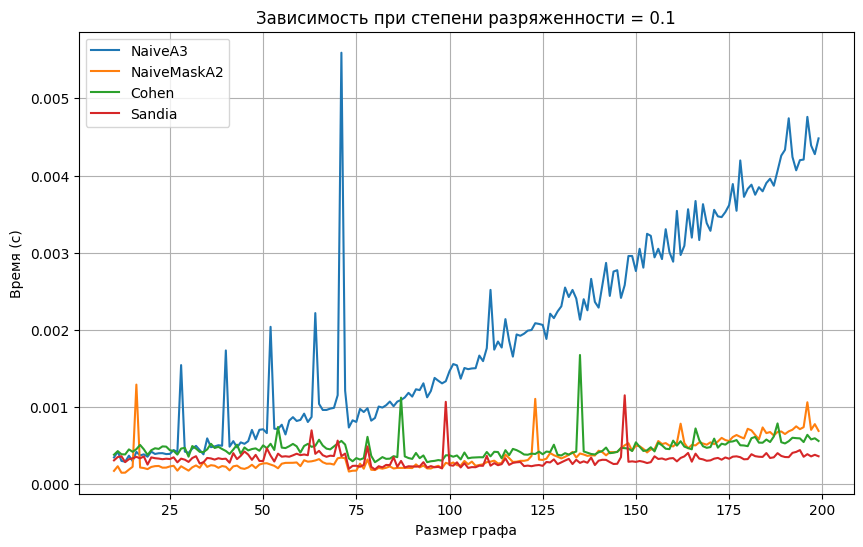

In [360]:
results_random = {}
for num_vertices in np.arange(10, 200):
    graph = generate_random_graph(num_vertices, sparsity=0.1)
    times = calculate_time(graph)
    results_random[num_vertices] = times

num_vertices_list = list(results_random.keys())
naive_a3_times_random = [results_random[count][0] for count in num_vertices_list]
naive_mask_a2_times_random = [results_random[count][1] for count in num_vertices_list]
cohen_times_random = [results_random[count][2] for count in num_vertices_list]
sandia_times_random = [results_random[count][3] for count in num_vertices_list]


fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(num_vertices_list, naive_a3_times_random, label='NaiveA3')
ax.plot(num_vertices_list, naive_mask_a2_times_random, label='NaiveMaskA2')
ax.plot(num_vertices_list, cohen_times_random, label='Cohen')
ax.plot(num_vertices_list, sandia_times_random, label='Sandia')

ax.set_xlabel('Размер графа')
ax.set_ylabel('Время (с)')
ax.set_title('Зависимость при степени разряженности = 0.1')
ax.legend()
ax.grid(True)
plt.show()

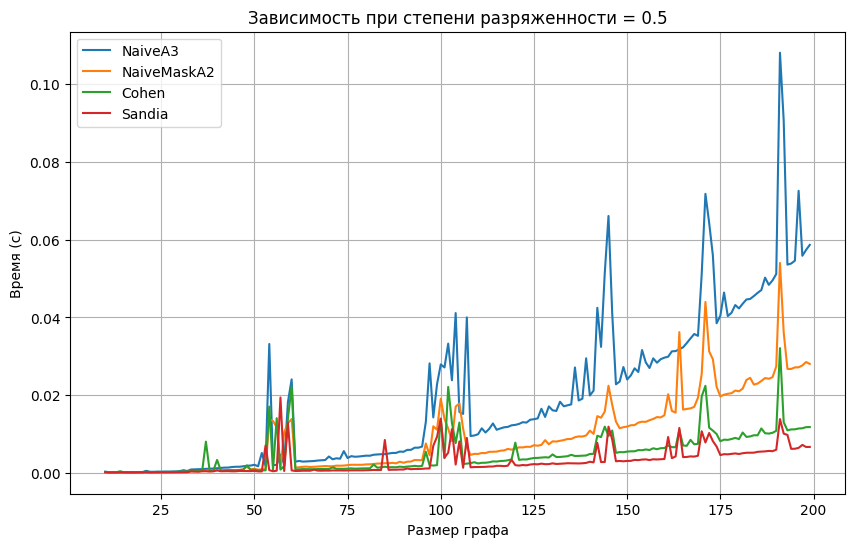

In [361]:
results_random = {}
for num_vertices in np.arange(10, 200):
    graph = generate_random_graph(num_vertices, sparsity=0.5)
    times = calculate_time(graph)
    results_random[num_vertices] = times

num_vertices_list = list(results_random.keys())
naive_a3_times_random = [results_random[count][0] for count in num_vertices_list]
naive_mask_a2_times_random = [results_random[count][1] for count in num_vertices_list]
cohen_times_random = [results_random[count][2] for count in num_vertices_list]
sandia_times_random = [results_random[count][3] for count in num_vertices_list]


fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(num_vertices_list, naive_a3_times_random, label='NaiveA3')
ax.plot(num_vertices_list, naive_mask_a2_times_random, label='NaiveMaskA2')
ax.plot(num_vertices_list, cohen_times_random, label='Cohen')
ax.plot(num_vertices_list, sandia_times_random, label='Sandia')

ax.set_xlabel('Размер графа')
ax.set_ylabel('Время (с)')
ax.set_title('Зависимость при степени разряженности = 0.5')
ax.legend()
ax.grid(True)
plt.show()

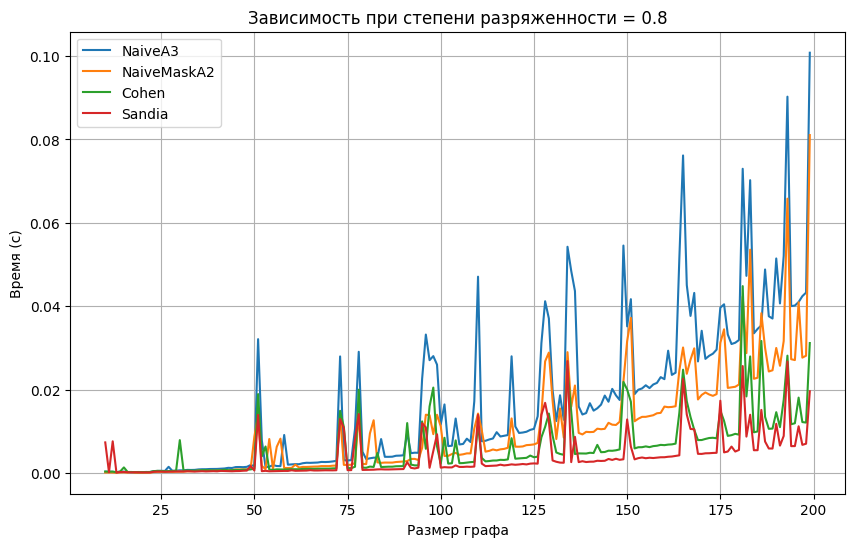

In [363]:
results_random = {}
for num_vertices in np.arange(10, 200):
    graph = generate_random_graph(num_vertices, sparsity=0.8)
    times = calculate_time(graph)
    results_random[num_vertices] = times

num_vertices_list = list(results_random.keys())
naive_a3_times_random = [results_random[count][0] for count in num_vertices_list]
naive_mask_a2_times_random = [results_random[count][1] for count in num_vertices_list]
cohen_times_random = [results_random[count][2] for count in num_vertices_list]
sandia_times_random = [results_random[count][3] for count in num_vertices_list]


fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(num_vertices_list, naive_a3_times_random, label='NaiveA3')
ax.plot(num_vertices_list, naive_mask_a2_times_random, label='NaiveMaskA2')
ax.plot(num_vertices_list, cohen_times_random, label='Cohen')
ax.plot(num_vertices_list, sandia_times_random, label='Sandia')

ax.set_xlabel('Размер графа')
ax.set_ylabel('Время (с)')
ax.set_title('Зависимость при степени разряженности = 0.8')
ax.legend()
ax.grid(True)
plt.show()

Выводы:


1.   При высокой степени разряженности (sparsity=0.1) увеличение размера матрицы смежности для наивного подхода (A^3) приводит к значительному увеличению времени работы, для остальных методов время работы не так быстро растет.
2.   В случае средней степени разряженности (sparsity=0.5), увеличение размера матрицы смежности приводит к тому что время работы для разных алгоритмов более заметно, алгоритм Sandia показывает наилучший результат.
3. При высокой степени разряженности (sparsity=0.9) с увеличением размера матрицы смежности время растет быстро для всех методов, несмотря на то что алгоритм Sandia все еще показывает наилучший результат, разница уже не столь заметна.

**Можно сделать вывод: что с увеличением размера матрицы смежности хороший алгоритмы будут показывать себя тем лучше, чем выше степень разряженности.**